In [5]:
import trimesh
import numpy as np
from scipy import integrate, optimize
import math

In [24]:
trimesh.load("../../../Blender/oblique/obliquedeform2.obj").volume

0.0

In [21]:
def R(x, s, C):
    return s * np.sqrt(1.2**2 - x**2) * (0.1*x + C)

def A_slice(x, s, u, C):
    d = 2*x + u
    R0 = R(x, s, C)
    if d >= R0:
        return 0.0  # Entire disk is below the plane → remove all
    elif d <= -R0:
        return np.pi * R0**2  # Entire disk is above the plane → keep all
    else:
        return R0**2 * np.arccos(d / R0) - d * np.sqrt(R0**2 - d**2)

def V_total(s, u, C):
    f = lambda x: A_slice(x, s, u, C)
    return integrate.quad(f, -1.2, 1.2)[0]

def find_s(u, C):
    # target volume = 1.4*pi
    target = 1.4*np.pi
    root = optimize.brentq(lambda s: V_total(s, u, C) - target,
                          a=1e-3, b=1e3)
    return root

C = np.sqrt(544283/10)/300
V_total(1, -3, C)
find_s(-1, C)

1.167870516925169

In [20]:
V_total(1, -1, C)

3.2467044950125805

In [33]:
import torch
from pytorch3d.structures import Meshes
from pytorch3d.io import load_obj

def project_silhouette(mesh: Meshes, P: torch.Tensor):
    # 1. Unpack verts/faces
    V = mesh.verts_packed()          # (V_total, 3)
    F = mesh.faces_packed()          # (F_total, 3)

    # 2. Project vertices into “pixel” (or clip) space
    Vh = torch.cat([V, torch.ones_like(V[:, :1])], dim=1)    # (V,4)
    Vc = (P @ Vh.T).T                                       # (V,3)
    xy = Vc[:, :2] / Vc[:, 2:3]                             # (V,2)

    # 3. Compute face normals in camera coords
    #    (just like trimesh.face_normals but in torch)
    v0 = Vc[F[:, 0]]
    v1 = Vc[F[:, 1]]
    v2 = Vc[F[:, 2]]
    fn = torch.cross(v1 - v0, v2 - v0, dim=1)               # (F,3)
    fn = fn / fn.norm(dim=1, keepdim=True)

    # 4. Decide which faces are front‐facing
    #    camera looks down its +z, so dot(fn, [0,0,1]) > 0
    front = fn[:, 2] > 0

    # 5. Build an edge list, find silhouette edges
    #    (for each face record its 3 edges, sort their verts so edges are canonical)
    edges = torch.cat([F[:, [0,1]], F[:, [1,2]], F[:, [2,0]]], dim=0)  # (3F,2)
    edges = edges.sort(dim=1)[0]                                        # sort verts in each edge
    face_idx = torch.arange(F.shape[0], device=V.device).repeat_interleave(3)
    front_mask = front[face_idx]

    # pick edges belonging to exactly one front face
    # group by edge, count how many front faces mention it
    unique_edges, inv = torch.unique(edges, return_inverse=True, dim=0)
    counts = torch.zeros(len(unique_edges), device=V.device).scatter_add_(0, inv, front_mask.float())
    sil_edges = unique_edges[counts == 1]   # (E_sil,2)

    # 6. Pull their projected 2D coords
    loops = []
    for e in sil_edges:
        loops.append(xy[e].cpu().numpy())    # shape (2,2) in image space

    # Now you have a cloud of 2‐point line segments which you can chain into polygons
    # (e.g. via a simple graph‐walk) to get closed loops.
    xy_np = xy.cpu().numpy()  
    sil_edges_np = np.stack(loops, axis=0)   # shape (E,2,2)

    return xy_np, sil_edges_np

import numpy as np
import matplotlib.pyplot as plt

def visualize_projection(xy: np.ndarray,
                         silhouette_edges: np.ndarray,
                         figsize=(6,6),
                         point_kwargs=None,
                         edge_kwargs=None):
    """
    Plot 2D points and highlight the silhouette (boundary) edges.

    Args:
        xy (np.ndarray of shape (N,2)):
            The projected 2D coordinates of all mesh vertices.
        silhouette_edges (np.ndarray of shape (E,2,2)):
            An array of E boundary edges, each given by its two 2D endpoints.
        figsize (tuple):
            Figure size passed to plt.figure().
        point_kwargs (dict, optional):
            Passed to plt.scatter for interior points.
        edge_kwargs (dict, optional):
            Passed to plt.plot for the silhouette edges.
    """
    # defaults
    if point_kwargs is None:
        point_kwargs = dict(marker='.', s=8, alpha=0.5)
    if edge_kwargs is None:
        edge_kwargs = dict(linestyle='-', marker='o', markersize=4)

    fig, ax = plt.subplots(figsize=figsize)
    # plot all points
    ax.scatter(xy[:,0], xy[:,1], **point_kwargs)

    # collect unique boundary vertices so we can overplot them distinctly
    # (optional—here we also draw the connecting lines)
    # plot each edge
    for e in silhouette_edges:
        xs = e[:,0]
        ys = e[:,1]
        ax.plot(xs, ys, **edge_kwargs)

    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Projected Mesh & Silhouette Edges')
    plt.tight_layout()
    plt.show()



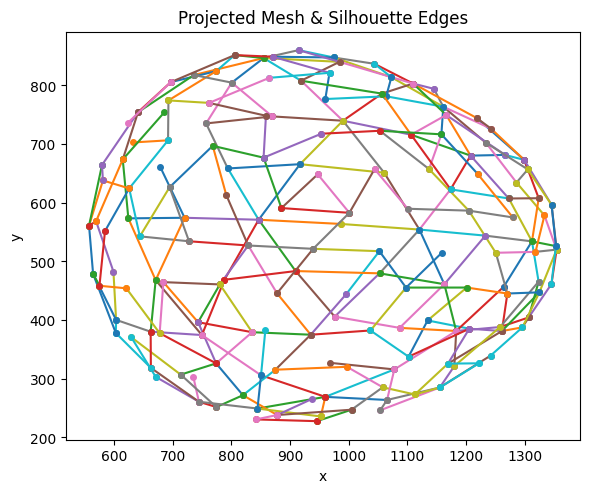

In [34]:
verts, faces, aux = load_obj("/Users/jeffreyliang/Documents/Honours/honours/src/data/meshes/balloon_2.obj")
# Create Meshes object in PyTorch3D
balloon = Meshes(verts=[verts], faces=[faces.verts_idx])
P = torch.tensor(np.load("/Users/jeffreyliang/Documents/Honours/honours/src/data/sky/cameras/Camera_2_P.npy")).float()
xy, sil_edges = project_silhouette(balloon, P)
visualize_projection(xy, sil_edges)


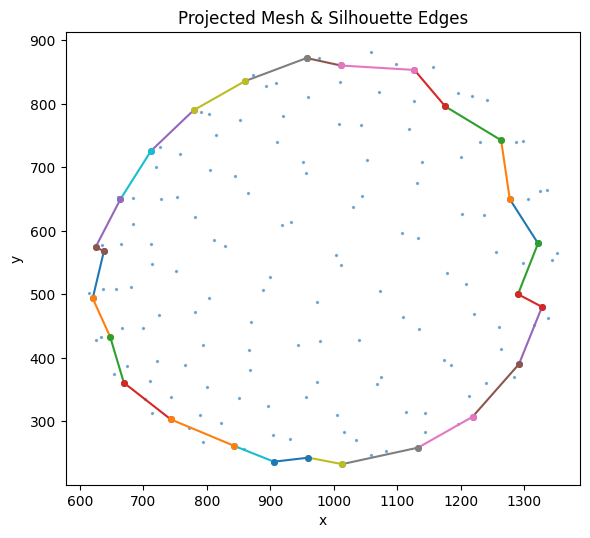

In [71]:
import torch
import numpy as np
from collections import defaultdict
from pytorch3d.structures import Meshes

def project_silhouette(
    mesh: Meshes,
    P: torch.Tensor,
    ignore_sign: bool = True,
    tol_dot: float = 1e-10
):
    """
    Projects a PyTorch3D mesh through a 3×4 projection matrix P
    and extracts the 2D boundary (silhouette) edges.

    Args:
        mesh:        a pytorch3d.structures.Meshes object (single mesh).
        P:           a (3,4) torch.Tensor projection matrix.
        ignore_sign: if True, choose the smaller side of front/back faces.
        tol_dot:     tolerance for dropping nearly perpendicular faces.

    Returns:
        xy_np:        (V,2) numpy array of projected vertex coordinates.
        sil_edges_np: (E_boundary, 2, 2) numpy array of boundary edge segments.
    """
    # 1) Unpack vertices and faces
    V = mesh.verts_packed()      # (V,3)
    F = mesh.faces_packed()      # (F,3)

    # 2) Project vertices (homogeneous → clip → NDC)
    Vh = torch.cat([V, torch.ones_like(V[:, :1])], dim=1)   # (V,4)
    Vc = (P @ Vh.T).T                                      # (V,3)
    xy = Vc[:, :2] / Vc[:, 2:3]                            # (V,2)

    # 3) Compute face normals in camera space
    v0, v1, v2 = Vc[F[:,0]], Vc[F[:,1]], Vc[F[:,2]]
    fn = torch.cross(v1 - v0, v2 - v0, dim=1)
    fn = fn / (fn.norm(dim=1, keepdim=True) + 1e-9)

    # 4) Classify front/back faces
    dot   = fn[:, 2]
    front = dot >  tol_dot
    back  = dot < -tol_dot

    # 5) ignore_sign logic: pick whichever side is smaller
    if ignore_sign:
        side = front if front.sum() <= back.sum() else back
    else:
        side = front

    # 6) Build face→edges mapping
    f2e     = mesh.faces_packed_to_edges_packed().cpu().numpy()  # (F,3)
    edges_np = mesh.edges_packed().cpu().numpy()                 # (E,2)
    E        = edges_np.shape[0]

    # 7) Invert to get edge→faces map
    e2f = [[] for _ in range(E)]
    for fi, e_idxs in enumerate(f2e):
        for e in e_idxs:
            e2f[e].append(fi)

    # 8) Build adjacency among faces in `side`
    neighbors = defaultdict(set)
    for e, faces in enumerate(e2f):
        if len(faces) == 2:
            f0, f1 = faces
            if side[f0] and side[f1]:
                neighbors[f0].add(f1)
                neighbors[f1].add(f0)

    # 9) Connected components of faces in `side`
    visited    = set()
    face_groups = []
    side_idxs  = torch.nonzero(side, as_tuple=False).squeeze().tolist()
    for f in side_idxs:
        if f in visited:
            continue
        stack, comp = [f], []
        while stack:
            curr = stack.pop()
            if curr in visited:
                continue
            visited.add(curr)
            comp.append(curr)
            for nb in neighbors[curr]:
                if nb not in visited:
                    stack.append(nb)
        face_groups.append(comp)

    # 10) For each component, keep edges used exactly once
    xy_np = xy.cpu().numpy()
    sil_edges_list = []
    for comp in face_groups:
        counts = defaultdict(int)
        for fi in comp:
            for e in f2e[fi]:
                counts[e] += 1
        boundary = [e for e, c in counts.items() if c == 1]
        for e in boundary:
            v0, v1 = edges_np[e]
            seg     = xy_np[[v0, v1], :]   # row-index the two verts
            sil_edges_list.append(seg)

    sil_edges_np = np.stack(sil_edges_list, axis=0)  # (E_boundary,2,2)
    return xy_np, sil_edges_np



verts, faces, aux = load_obj("/Users/jeffreyliang/Documents/Honours/honours/src/data/meshes/balloon_2.obj")
# Create Meshes object in PyTorch3D
balloon = Meshes(verts=[verts], faces=[faces.verts_idx])
P = torch.tensor(np.load("/Users/jeffreyliang/Documents/Honours/honours/src/data/sky/cameras/Camera_3_P.npy")).float()
xy, sil_edges = project_silhouette(balloon, P)
visualize_projection(xy, sil_edges)


In [85]:
last = np.load("../data/sky/cameras/Camera_7_RT.npy")[2]
last
last[:2]

array([ 0.44627151, -0.85926825])

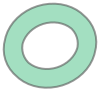

In [153]:
tri_balloon = trimesh.load("/Users/jeffreyliang/Documents/Honours/Blender/torus.obj")
trimesh.path.polygons.projected(tri_balloon, last[:3], precise=True)

In [114]:
import torch
from pytorch3d.structures import Meshes

def build_face_adjacency(mesh: Meshes):
    faces_to_edges = mesh.faces_packed_to_edges_packed()
    num_edges      = mesh.edges_packed().shape[0]

    edge_to_faces = [[] for _ in range(num_edges)]
    for f_idx, edge_idxs in enumerate(faces_to_edges.tolist()):
        for e in edge_idxs:
            edge_to_faces[e].append(f_idx)

    # collect only the 2‐face edges for adjacency pairs
    adj_pairs = [faces for faces in edge_to_faces if len(faces) == 2]
    face_adjacency = (
        torch.tensor(adj_pairs, dtype=torch.long) if adj_pairs
        else torch.zeros((0,2), dtype=torch.long)
    )

    return face_adjacency, edge_to_faces

def project_silhouette_p3d(mesh: Meshes, P: torch.Tensor):
    verts = mesh.verts_packed()       # (V,3)
    faces = mesh.faces_packed()       # (F,3)

    # build face_adjacency & edge_to_faces
    faces_to_edges = mesh.faces_packed_to_edges_packed()  # (F,3)
    num_edges      = mesh.edges_packed().shape[0]
    edge_to_faces  = [[] for _ in range(num_edges)]
    for f, es in enumerate(faces_to_edges.tolist()):
        for e in es:
            edge_to_faces[e].append(f)

    adj_pairs = [fs for fs in edge_to_faces if len(fs)==2]
    face_adjacency = torch.tensor(adj_pairs, dtype=torch.long) if adj_pairs else torch.zeros((0,2),dtype=torch.long)

    # project verts
    ones   = verts.new_ones(verts.shape[0],1)
    proj4  = (P @ torch.cat([verts,ones],1).t()).t()       # (V,3)
    xy     = proj4[:,:2] / proj4[:,2:3]                   # (V,2)

    # compute facing
    R      = P[:,:3]
    fnorms = mesh.faces_normals_packed()                  # (F,3)
    fn_cam = fnorms @ R.t()                               # (F,3)
    facing = fn_cam[:,2] > 0
    print(f"[DEBUG] faces total={fnorms.shape[0]}, front‑facing={facing.sum().item()}")

    # build e2f incidence tensor
    e2f = torch.full((num_edges,2), -1, dtype=torch.long)
    for e, fs in enumerate(edge_to_faces):
        for i, f in enumerate(fs):
            e2f[e,i] = f

    # silhouette = those edges with one front‑facing & one back‑facing face
    sil_mask = (facing[e2f[:,0]] != facing[e2f[:,1]])
    print(f"[DEBUG] edges total={num_edges}, silhouette edges={sil_mask.sum().item()}")

    sil_edges = mesh.edges_packed()[sil_mask]

    segments = [ (xy[v0].cpu().tolist(), xy[v1].cpu().tolist())
                 for v0,v1 in sil_edges ]
    xy_np = xy.cpu().numpy()


    fig, ax = plt.subplots()
    # scatter the projected vertices
    ax.scatter(xy_np[:,0], xy_np[:,1], s=4)

    # draw each silhouette edge
    for (p0, p1) in segments:
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]])

    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Projected vertices & silhouette')
    plt.show()
   
    return xy, segments

from shapely.geometry import LineString, MultiLineString
from shapely.ops      import unary_union, polygonize

def silhouette_polygon(xy, segments, padding=0.0):
    """
    xy:        (V,2) torch.Tensor or np.ndarray of projected pts
    segments:  list of ((x0,y0),(x1,y1)) silhouette segments
    padding:   optional buffer padding (same as rpad/apad in Trimesh)
    Returns:   a Shapely Polygon of the outer outline
    """
    # 1) build lines
    lines = [LineString([p0, p1]) for p0, p1 in segments]

    # 2) merge all into one geometry
    merged = unary_union(MultiLineString(lines))

    # 3) polygonize into closed polygons
    polys = list(polygonize(merged))
    if not polys:
        return None

    # 4) pick the outermost ring (max area) and buffer if desired
    outer = max(polys, key=lambda p: p.area)
    if padding:
        outer = outer.buffer(padding).buffer(-padding)
    return outer



[DEBUG] faces total=320, front‑facing=160
[DEBUG] edges total=480, silhouette edges=66


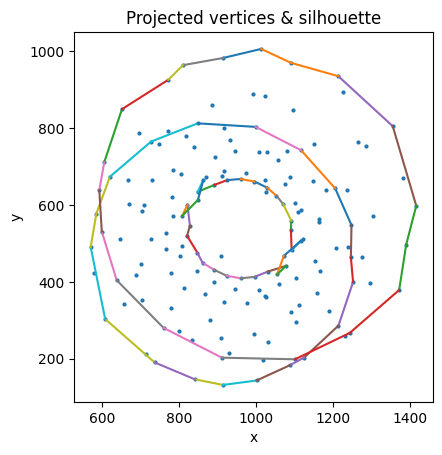

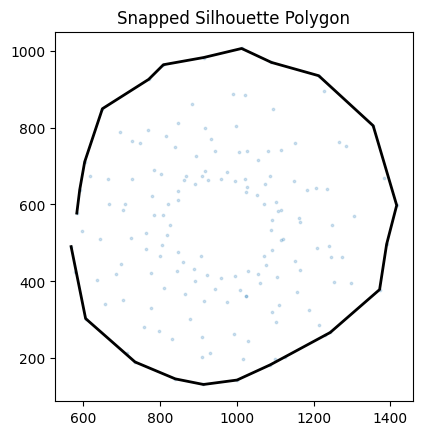

[tensor([[ 584.2793,  577.6429],
         [ 591.9036,  638.5720],
         [ 604.7111,  710.7772],
         [ 650.8732,  849.0965],
         [ 771.2764,  925.4722],
         [ 809.4402,  963.4648],
         [ 914.2576,  982.2348],
         [1012.8810, 1005.7302],
         [1090.4772,  969.4744],
         [1213.3617,  934.8936],
         [1354.9725,  804.8607],
         [1416.1416,  597.8672],
         [1390.0061,  496.9187],
         [1371.6968,  378.7603],
         [1243.2552,  267.1351],
         [1124.8655,  203.2602],
         [1086.9651,  182.8998],
         [1001.0134,  143.4928],
         [ 913.6699,  131.9592],
         [ 840.4564,  146.5121],
         [ 735.7232,  190.4379],
         [ 607.1532,  303.3878],
         [ 569.4981,  490.4603]])]

In [170]:
verts, faces, aux = load_obj("/Users/jeffreyliang/Documents/Honours/honours/src/data/meshes/parabola_2.obj")
# Create Meshes object in PyTorch3D
balloon = Meshes(verts=[verts], faces=[faces.verts_idx])
P = torch.tensor(np.load("/Users/jeffreyliang/Documents/Honours/honours/src/data/sky/cameras/Camera_4_P.npy")).float()
xy, segments = project_silhouette_p3d(balloon, P)


project_outline_p3d(balloon, P)
# # if you used rpad/apad to compute a padding value in your function, pass it here
# poly = silhouette_polygon(xy, segments, padding=0)

# # to plot:
# xs, ys = poly.exterior.xy
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots()
# ax.plot(xs, ys, '-k', linewidth=2)
# ax.set_aspect('equal')
# plt.show()


In [178]:
from math import log2
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch3d.structures import Meshes
import trimesh
from trimesh.grouping import group_rows
from trimesh.path.polygons import edges_to_polygons

def reduce_cascade(operation, items):
    """
    Call an operation function in a cascaded pairwise way against a
    flat list of items.

    This should produce the same result as `functools.reduce`
    if `operation` is commutable like addition or multiplication.
    This may be faster for an `operation` that runs with a speed
    proportional to its largest input, which mesh booleans appear to.

    The union of a large number of small meshes appears to be
    "much faster" using this method.

    This only differs from `functools.reduce` for commutative `operation`
    in that it returns `None` on empty inputs rather than `functools.reduce`
    which raises a `TypeError`.

    Parameters
    ----------
    operation
      The function to call on pairs of items.
    items
      The flat list of items to apply operation against.
    """
    if len(items) == 0:
        return None
    elif len(items) == 1:
        # skip the loop overhead for a single item
        return items[0]
    elif len(items) == 2:
        # skip the loop overhead for a single pair
        return operation(items[0], items[1])

    for _ in range(int(1 + log2(len(items)))):
        results = []

        # loop over pairs of items.
        items_mod = len(items) % 2
        for i in range(0, len(items) - items_mod, 2):
            results.append(operation(items[i], items[i + 1]))

        # if we had a non-even number of items it will have been
        # skipped by the loop so append it to our list
        if items_mod != 0:
            results.append(items[-1])

        items = results

    # logic should have reduced to a single item
    assert len(results) == 1

    return results[0]


def build_face_adjacency(mesh: Meshes):
    faces_to_edges = mesh.faces_packed_to_edges_packed()  # (F,3)
    num_edges      = mesh.edges_packed().shape[0]

    # invert to get list of faces per edge
    edge_to_faces = [[] for _ in range(num_edges)]
    for f_idx, edge_idxs in enumerate(faces_to_edges.tolist()):
        for e in edge_idxs:
            edge_to_faces[e].append(f_idx)

    # any edge with exactly two faces gives one adjacency pair
    adj_pairs = [faces for faces in edge_to_faces if len(faces) == 2]
    face_adjacency = (
        torch.tensor(adj_pairs, dtype=torch.long) 
        if adj_pairs 
        else torch.zeros((0,2), dtype=torch.long)
    )

    return face_adjacency, edge_to_faces
from shapely.geometry import Polygon

def project_outline_p3d(
    mesh: Meshes,
    P: torch.Tensor,
    ignore_sign: bool = True,
    tol_dot:    float = 1e-10,
    rpad:       float = 1e-5,
    apad:       float = None,
    precise=True,
    eps   = 1e-3
):
    # 1) unpack and project vertices to 2D
    verts = mesh.verts_packed()                          # (V,3)
    ones  = verts.new_ones(verts.shape[0], 1)
    proj4 = (P @ torch.cat([verts, ones], dim=1).t()).t()  # (V,3)
    xy    = proj4[:, :2] / proj4[:, 2:3]                 # (V,2)
    V2    = xy.cpu().numpy()                             # for Shapely

    # 2) compute which faces are on the “visible” side
    faces_to_edges = mesh.faces_packed_to_edges_packed()  # (F,3)
    R              = P[:, :3]
    fnorms         = mesh.faces_normals_packed()         # (F,3)
    fn_cam         = fnorms @ R.t()                      # (F,3)
    dot            = fn_cam[:, 2]
    if ignore_sign:
        front = dot >  tol_dot
        back  = dot < -tol_dot
        counts = torch.tensor([front.sum(), back.sum()])
        # pick the side with fewer triangles (or the only nonzero side)
        pick = int(torch.argmin(counts) if counts.min()>0 else torch.argmax(counts))
        side = (front, back)[pick]
    else:
        side = dot > tol_dot

    faces_np = mesh.faces_packed().cpu().numpy()              # (F,3)
    side_idx = np.nonzero(side.cpu().numpy())[0]

    if precise:
        # — Trimesh “precise” union of all projected triangles —
        tris = [Polygon(V2[faces_np[i]]) for i in side_idx]
        unioned = unary_union(tris).buffer(eps).buffer(-eps)

        rings = [np.array(unioned.exterior.coords)]
        rings += [np.array(r.coords) for r in unioned.interiors]
        def snap_ring_to_torch(xy, ring_coords):
            coords_t = torch.from_numpy(ring_coords).to(xy)
            diffs    = coords_t[:,None,:] - xy[None,:,:]
            d2       = (diffs**2).sum(dim=2)
            idx      = torch.argmin(d2, dim=1)
            idx_u    = torch.unique_consecutive(idx)
            if idx_u.numel()>1 and idx_u[0]==idx_u[-1]:
                idx_u = idx_u[:-1]
            return xy[idx_u]  # (L_unique,2)

        loop_pts_list = [ snap_ring_to_torch(xy, rc) for rc in rings ]

        plt.figure()
        # first, scatter all projected verts
        plt.scatter(V2[:,0], V2[:,1], s=3, alpha=0.2)

        # now plot each loop (outer and any inner holes)
        for loop_pts in loop_pts_list:
            pts = loop_pts.detach().cpu().numpy()
            plt.plot(pts[:,0], pts[:,1], '-k', linewidth=2)

        plt.gca().set_aspect('equal')
        plt.title('Snapped Silhouette Polygon')
        plt.show()

        # return all loops so caller can use them
        return loop_pts_list

    # 3) build face–adjacency graph
    face_adjacency, edge_to_faces = build_face_adjacency(mesh)
    adj_np = face_adjacency.cpu().numpy()  # (A,2)
    face_groups = trimesh.graph.connected_components(adj_np, nodes=side_idx)

    # 4) for each connected group, extract its boundary loops
    E2 = mesh.edges_packed().cpu().numpy()       # (E,2)
    F2 = mesh.faces_packed().cpu().numpy()       # (F,3)
    F2e= faces_to_edges.cpu().numpy()            # (F,3)
    polygons = []
    for group in face_groups:
        group = np.array(list(group), dtype=int)
        # gather all edge‐indices for these faces
        edge_idxs = F2e[group].reshape(-1)
        # turn into vertex‐pairs
        ev = E2[edge_idxs]                        # (n_faces*3, 2)
        # sort each pair so uniqueness works
        ev_sorted = np.sort(ev, axis=1)
        # keep only those that occur once (the true boundary)
        mask = group_rows(ev_sorted, require_count=1)
        boundary = ev_sorted[mask]
        # build Shapely polygons for each loop
        polygons.extend(edges_to_polygons(boundary, V2))

    # 5) compute padding
    padding = 0.0
    if apad is not None:
        padding += float(apad)
    if rpad is not None:
        padding += float(rpad) * V2.ptp(axis=0).max()

    # 6) union all loops via a balanced cascade
    if not polygons:
        return torch.zeros((0,2), device=xy.device)
    if len(polygons) == 1:
        outline = polygons[0]
    else:
        outline = reduce_cascade(lambda a, b: a.union(b), polygons)
    if padding:
        outline = outline.buffer(padding).buffer(-padding)

    # 7) snap shapely exterior coords back to nearest torch points

    rings = [np.array(outline.exterior.coords)]
    rings += [np.array(r.coords) for r in outline.interiors]
    def snap_ring_to_torch(xy, ring_coords):
        coords_t = torch.from_numpy(ring_coords).to(xy)
        diffs    = coords_t[:,None,:] - xy[None,:,:]
        d2       = (diffs**2).sum(dim=2)
        idx      = torch.argmin(d2, dim=1)
        idx_u    = torch.unique_consecutive(idx)
        if idx_u.numel()>1 and idx_u[0]==idx_u[-1]:
            idx_u = idx_u[:-1]
        return xy[idx_u]  # (L_unique,2)

    loop_pts_list = [ snap_ring_to_torch(xy, rc) for rc in rings ]

    plt.figure()
    # first, scatter all projected verts
    plt.scatter(V2[:,0], V2[:,1], s=3, alpha=0.2)

    # now plot each loop (outer and any inner holes)
    for loop_pts in loop_pts_list:
        pts = loop_pts.detach().cpu().numpy()
        plt.plot(pts[:,0], pts[:,1], '-k', linewidth=2)

    plt.gca().set_aspect('equal')
    plt.title('Snapped Silhouette Polygon')
    plt.show()

    # return all loops so caller can use them
    return loop_pts_list


/Users/jeffreyliang/Documents/Honours/venv/lib/python3.12/site-packages/pytorch3d/io/obj_io.py:547: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


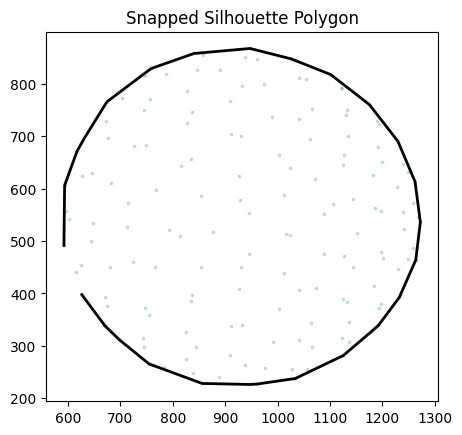

[tensor([[ 592.0751,  491.6075],
         [ 593.3962,  606.2918],
         [ 616.8866,  671.0048],
         [ 629.2623,  693.3863],
         [ 674.1519,  765.9109],
         [ 758.4754,  829.3489],
         [ 840.2614,  858.1149],
         [ 947.5087,  867.6827],
         [1026.1018,  847.7964],
         [1101.4553,  817.8176],
         [1175.3575,  760.4984],
         [1229.7600,  690.3004],
         [1262.3368,  613.6589],
         [1272.5400,  536.1565],
         [1263.7589,  463.9908],
         [1232.2920,  392.4020],
         [1192.4095,  338.9911],
         [1178.3085,  326.5611],
         [1125.3170,  281.4723],
         [1033.6674,  237.6352],
         [ 960.0002,  226.9744],
         [ 947.2548,  226.2463],
         [ 855.8394,  228.2245],
         [ 754.8785,  265.3591],
         [ 698.6199,  310.9508],
         [ 670.2925,  338.4032],
         [ 626.1815,  397.7620]])]

In [179]:
verts, faces, aux = load_obj("/Users/jeffreyliang/Documents/Honours/honours/src/data/meshes/balloon_2.obj")
balloon = Meshes(verts=[verts], faces=[faces.verts_idx])
P = torch.tensor(np.load("/Users/jeffreyliang/Documents/Honours/honours/src/data/sky/cameras/Camera_5_P.npy")).float()
project_outline_p3d(balloon, P, precise=True)

/Users/jeffreyliang/Documents/Honours/venv/lib/python3.12/site-packages/pytorch3d/io/obj_io.py:547: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


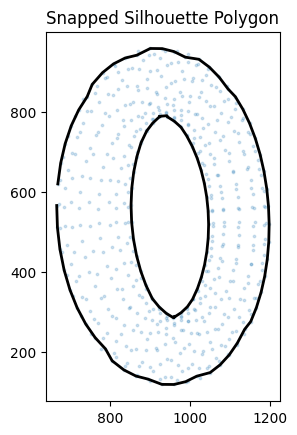

[tensor([[ 670.2239,  619.7654],
         [ 677.3604,  671.6961],
         [ 688.6589,  720.4290],
         [ 703.7726,  764.9123],
         [ 722.2628,  804.2612],
         [ 743.6199,  837.7786],
         [ 756.0380,  868.0084],
         [ 781.7584,  897.3143],
         [ 809.3008,  919.2603],
         [ 838.0344,  933.7451],
         [ 867.3557,  940.8474],
         [ 900.8514,  957.5996],
         [ 930.6854,  957.2582],
         [ 960.0002,  949.8807],
         [ 988.3388,  935.9402],
         [1022.2639,  930.6151],
         [1048.2250,  911.0862],
         [1072.5610,  886.1865],
         [1094.9954,  856.5001],
         [1113.1383,  837.3800],
         [1131.9347,  805.8876],
         [1148.6121,  770.9465],
         [1163.0194,  733.1045],
         [1175.0338,  692.9017],
         [1184.5576,  650.8713],
         [1191.5151,  607.5380],
         [1195.8489,  563.4212],
         [1197.5197,  519.0363],
         [1196.5040,  474.8992],
         [1192.7957,  431.5294],
         [

In [181]:
verts, faces, aux = load_obj("/Users/jeffreyliang/Documents/Honours/Blender/torus.obj")
balloon = Meshes(verts=[verts], faces=[faces.verts_idx])
P = torch.tensor(np.load("/Users/jeffreyliang/Documents/Honours/honours/src/data/sky/cameras/Camera_5_P.npy")).float()
project_outline_p3d(balloon, P, precise=True)


In [131]:
import torch
from pytorch3d.structures import Meshes

def silhouette_boundary_points(mesh: Meshes, P: torch.Tensor):
    """
    Returns a (M,2) tensor of 2D points lying along the silhouette
    of `mesh` under projection P, suitable for backprop.
    """
    # 1) project all vertices through P
    verts = mesh.verts_packed()                           # (V,3)
    ones  = verts.new_ones(verts.shape[0], 1)             # (V,1)
    H     = torch.cat([verts, ones], dim=1)               # (V,4)
    proj4 = (P @ H.t()).t()                               # (V,3)
    xy    = proj4[:, :2] / proj4[:, 2:3]                  # (V,2)

    # 2) compute which faces are front‑facing
    #    (P = K [R|t], so R = P[:,:3])
    R      = P[:, :3]                                     # (3,3)
    fn     = mesh.faces_normals_packed()                  # (F,3)
    fn_cam = fn @ R.t()                                   # (F,3)
    facing = fn_cam[:, 2] > 0                             # (F,) bool

    # 3) build edge→face incidence tensor e2f (E,2)
    #    e2f[e,0/1] = the two face‑indices incident on edge e, or -1
    E = mesh.edges_packed()                               # (E,2)
    num_edges = E.shape[0]
    e2f = torch.full((num_edges, 2), -1, dtype=torch.long, device=E.device)
    f2e = mesh.faces_packed_to_edges_packed()             # (F,3)
    # loop on faces → constant overhead, does not break grad
    for f in range(f2e.shape[0]):
        for slot, e in enumerate(f2e[f].tolist()):
            if e2f[e, 0] < 0:
                e2f[e, 0] = f
            else:
                e2f[e, 1] = f

    # 4) silhouette edges = edges with one front and one back face
    #    (ignore edges on the very boundary of the mesh with <2 faces)
    valid = (e2f[:, 0] >= 0) & (e2f[:, 1] >= 0)
    sil_mask = valid & (facing[e2f[:, 0]] != facing[e2f[:, 1]])
    sil_edges = E[sil_mask]                               # (S,2) vertex‑indices

    # 5) gather boundary points: two endpoints per edge
    #    shape (S,2,2) → reshape to (2*S,2)
    bpts = xy[sil_edges]                                  # (S,2,2)
    bpts = bpts.view(-1, 2)                               # (2S,2)

    return bpts
boundary_pts = silhouette_boundary_points(balloon, P)

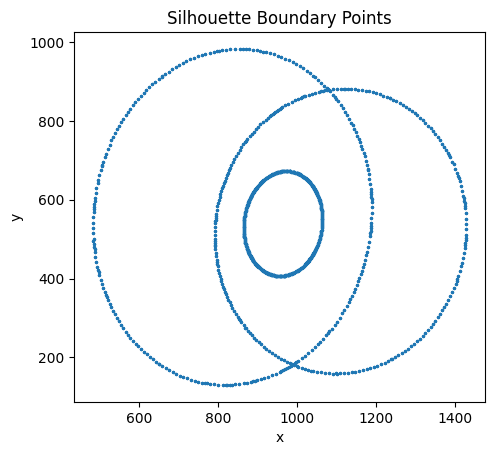

In [132]:
pts = boundary_pts.detach().cpu().numpy()

# Plot
plt.figure()
plt.scatter(pts[:, 0], pts[:, 1], s=2)
plt.gca().set_aspect('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Silhouette Boundary Points')
plt.show()


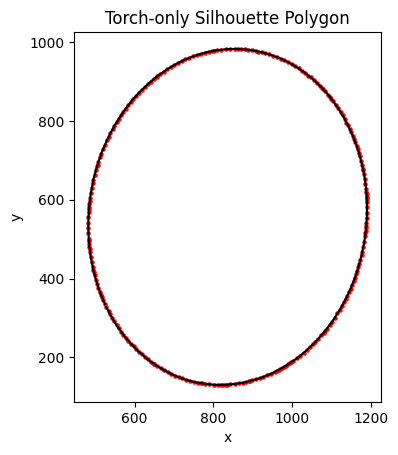

In [133]:
import torch
from pytorch3d.structures import Meshes

def silhouette_polygon_torch(mesh: Meshes, P: torch.Tensor):
    """
    Returns a (L,2) tensor of the ordered 2D points tracing the outer silhouette
    loop of `mesh` under projection P.  Fully differentiable w.r.t. mesh verts and P.
    """
    # 1) Project verts
    V = mesh.verts_packed()                                    # (V,3)
    H = torch.cat([V, V.new_ones(V.shape[0],1)], dim=1)        # (V,4)
    proj4 = (P @ H.t()).t()                                    # (V,3)
    xy    = proj4[:, :2] / proj4[:, 2:3]                       # (V,2)

    # 2) Find front/back‐facing faces
    R      = P[:, :3]                                          # (3,3)
    fn     = mesh.faces_normals_packed()                       # (F,3)
    facing = (fn @ R.t())[:, 2] > 0                            # (F,) bool

    # 3) Build edge→face map and pick silhouette edges
    E      = mesh.edges_packed().tolist()                      # list of [u,v]
    f2e    = mesh.faces_packed_to_edges_packed()               # (F,3)
    numE   = len(E)
    e2f    = [[] for _ in range(numE)]
    for f_idx, es in enumerate(f2e.tolist()):
        for e in es:
            e2f[e].append(f_idx)

    sil_edges = []
    for e, faces in enumerate(e2f):
        if len(faces)==2 and facing[faces[0]] != facing[faces[1]]:
            sil_edges.append(tuple(E[e]))
    # sil_edges: list of (u,v) for silhouette

    # 4) Chain edges into loops
    #    build adjacency map
    adj = {}
    for u,v in sil_edges:
        adj.setdefault(u, []).append(v)
        adj.setdefault(v, []).append(u)

    loops = []
    used = set()
    for edge in sil_edges:
        u0,v0 = edge
        if (u0,v0) in used: continue
        loop = [u0, v0]
        used.add((u0,v0)); used.add((v0,u0))
        # walk until we return to u0
        while True:
            prev, curr = loop[-2], loop[-1]
            nbrs = adj[curr]
            # pick the neighbor that isn't the one we came from
            nxt = nbrs[0] if nbrs[0] != prev else nbrs[1]
            if nxt==u0:
                break
            loop.append(nxt)
            used.add((curr,nxt)); used.add((nxt,curr))
        loops.append(loop)

    if not loops:
        return torch.zeros((0,2), device=xy.device)

    # 5) Compute loop areas via shoelace in torch, pick largest
    areas = []
    for loop in loops:
        pts = xy[torch.tensor(loop, device=xy.device)]       # (L_i,2)
        x, y = pts[:,0], pts[:,1]
        # shoelace: ½|Σ x_i y_{i+1} - x_{i+1} y_i|
        xp = torch.roll(x, -1); yp = torch.roll(y, -1)
        area = torch.abs(0.5 * torch.sum(x*yp - xp*y))
        areas.append(area)
    areas = torch.stack(areas)
    best = torch.argmax(areas).item()

    # 6) return the best loop’s coordinates
    best_loop = loops[best]
    polygon  = xy[torch.tensor(best_loop, device=xy.device)]    # (L,2)
    return polygon
poly_pts = silhouette_polygon_torch(balloon, P)   # (L,2) tensor
pts = poly_pts.detach().cpu().numpy()
plt.figure()
plt.plot(pts[:,0], pts[:,1], '-k')            # outline
plt.scatter(pts[:,0], pts[:,1], s=5, c='r')   # vertices
plt.gca().set_aspect('equal')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Torch‑only Silhouette Polygon')
plt.show()


In [182]:
def project_outline_precise(
    mesh: Meshes,
    P: torch.Tensor,
    eps: float = 1e-3
):
    """
    Compute the exact silhouette outline (outer ring + any holes)
    of a PyTorch3D mesh under the 3×4 projection matrix P.

    Returns:
        List[Tensor]: each element is an (Lᵢ, 2) tensor of 2D points
                      tracing one closed loop (exterior first, then holes).
    """
    # 1) Project all vertices into 2D
    verts = mesh.verts_packed()                                 # (V,3)
    ones  = torch.ones((verts.shape[0], 1), device=verts.device)
    H     = torch.cat([verts, ones], dim=1)                     # (V,4)
    proj4 = (P @ H.T).T                                         # (V,3)
    xy    = proj4[:, :2] / proj4[:, 2:3]                        # (V,2)
    V2    = xy.cpu().numpy()                                    # for Shapely

    # 2) Select front‑facing triangles only
    R       = P[:, :3]                                          # camera rotation
    fnorms  = mesh.faces_normals_packed()                       # (F,3)
    dot_z   = (fnorms @ R.T)[:, 2]                              # z‑component in camera space
    visible = dot_z > 0                                          # bool mask over faces
    faces_np = mesh.faces_packed().cpu().numpy()                # (F,3)
    vis_idx  = np.nonzero(visible.cpu().numpy())[0]             # indices of visible faces

    # 3) Build tiny Polygons for each visible triangle & union them
    tris    = [Polygon(V2[faces_np[i]]) for i in vis_idx]
    unioned = unary_union(tris).buffer(eps).buffer(-eps)

    # 4) Extract exterior + any interior rings
    rings = [np.array(unioned.exterior.coords)]
    for interior in unioned.interiors:
        rings.append(np.array(interior.coords))

    # 5) Snap each ring’s float coords back to nearest torch points
    loops = []
    for ring in rings:
        coords_t = torch.from_numpy(ring).to(xy)                 # (L,2)
        diffs    = coords_t[:, None, :] - xy[None, :, :]        # (L,V,2)
        d2       = (diffs**2).sum(dim=2)                        # (L,V)
        idx      = torch.argmin(d2, dim=1)                      # (L,)
        idx_u    = torch.unique_consecutive(idx)                # collapse dupes
        # drop final if it closes on the first
        if idx_u.numel() > 1 and idx_u[0] == idx_u[-1]:
            idx_u = idx_u[:-1]
        loops.append(xy[idx_u])                                 # (L_unique,2)

    return loops